In [1]:
using FourierFlows
using CairoMakie
using LinearAlgebra

In [2]:
struct Vars <: AbstractVars
    u :: Array{Float64, 1}
    uh :: Array{Complex{Float64}, 1}
end

struct Params <: AbstractParams
    ν :: Float64
end

function calcN!(N, sol, t, clock, vars, params, grid)
    vars.uh .= sol
    vars.u .= irfft(vars.uh, grid.nx)
    uxh = @. 1im * grid.kr * vars.uh
    ux = irfft(uxh, grid.nx)
    uux = @. -vars.u .* ux
    N .= rfft(uux)
    return nothing
end

nx = 128
Lx = 2π
grid = OneDGrid(; nx, Lx)

ν = 1#10*(nx/2+1)^(-8)
println(ν)
L = ν * grid.kr.^2
println(minimum(L))

params = Params(ν)
vars = Vars(zeros(Float64, (grid.nx,)), zeros(Complex{Float64}, (grid.nkr,)))

equation = FourierFlows.Equation(L, calcN!, grid)
stepper, dt = "AB3", 0.001


1
0.0


("AB3", 0.001)

In [3]:
function dEdt(uh)
    uxh = 1im * grid.kr .* uh
    u = irfft(uh, grid.nx)
    ux = irfft(uxh, grid.nx)
    uux = -u .* ux
    uuxh = rfft(uux)
    return 2*real(conj.(uh) .* (uuxh + params.ν * grid.kr.^2))
end

prob = FourierFlows.Problem(equation, stepper, dt, grid, vars, params)
u0 = @. exp(-grid.x.^2/1)
using LinearAlgebra: mul!
mul!(prob.sol, grid.rfftplan, u0)

stepforward!(prob, 5)
Th1 = dEdt(prob.sol)
t1 = prob.clock.t
sol1 = prob.sol[:]

stepforward!(prob, 1)
Th2 = dEdt(prob.sol)
sol2 = prob.sol[:]
t2 = prob.clock.t

u1 = irfft(sol1, grid.nx)
u2 = irfft(sol2, grid.nx)
println(grid.dx*(sum(u2.^2) - sum(u1.^2))/(t2 - t1))
println((FourierFlows.parsevalsum2(sol2, grid) - FourierFlows.parsevalsum2(sol1, grid))/(t2 - t1))
println(FourierFlows.parsevalsum(Th1, grid))
println(FourierFlows.parsevalsum(Th2, grid))

3.2874088757597137
3.2874088757604003
-2.467912287972759
-17.194890064001637


-3493.851537160256


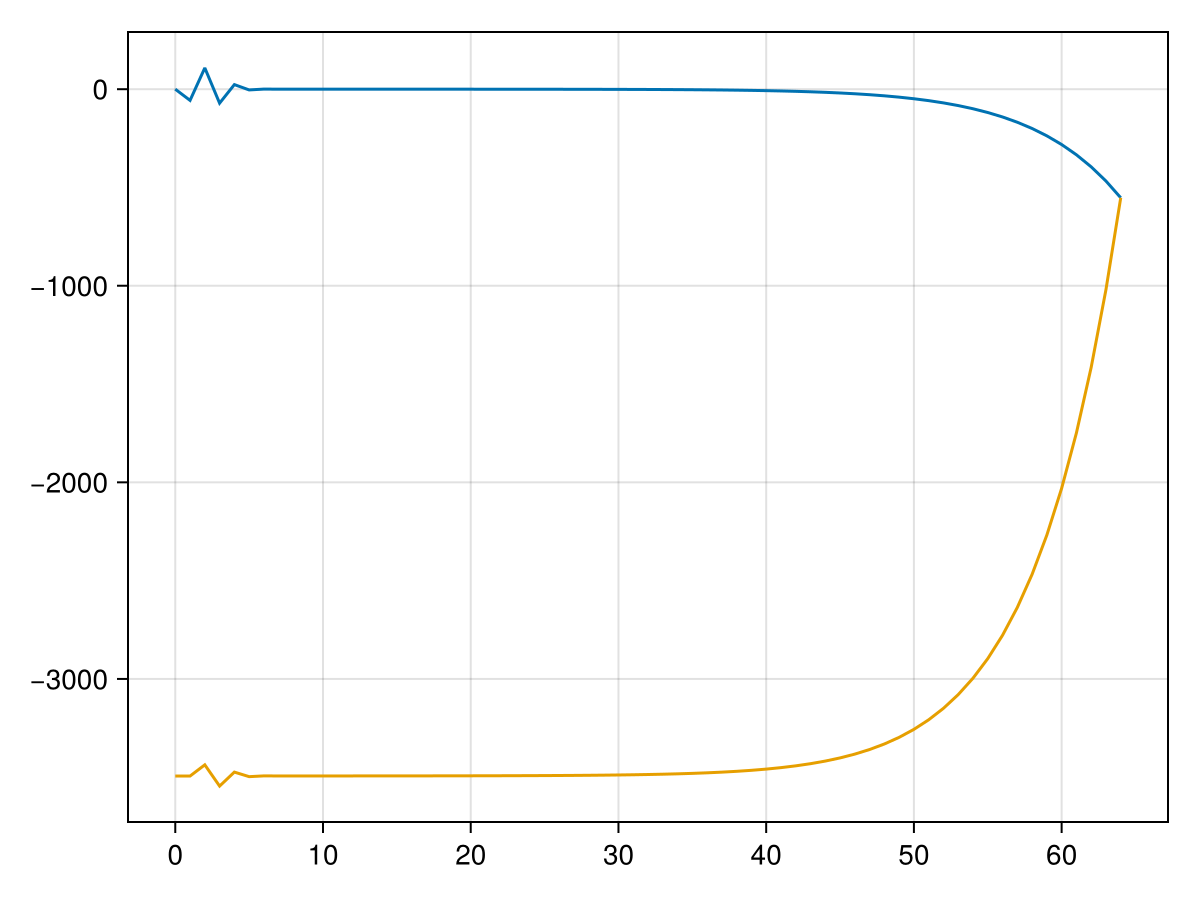

In [4]:
Πh1 = cumsum(Th1[end:-1:1])[end:-1:1]
println(sum(Th1))
fig = Figure()
ax = Axis(fig[1,1])
lines!(ax, grid.kr, Th1)
lines!(ax, grid.kr, Πh1)

fig

-3493.851537160256


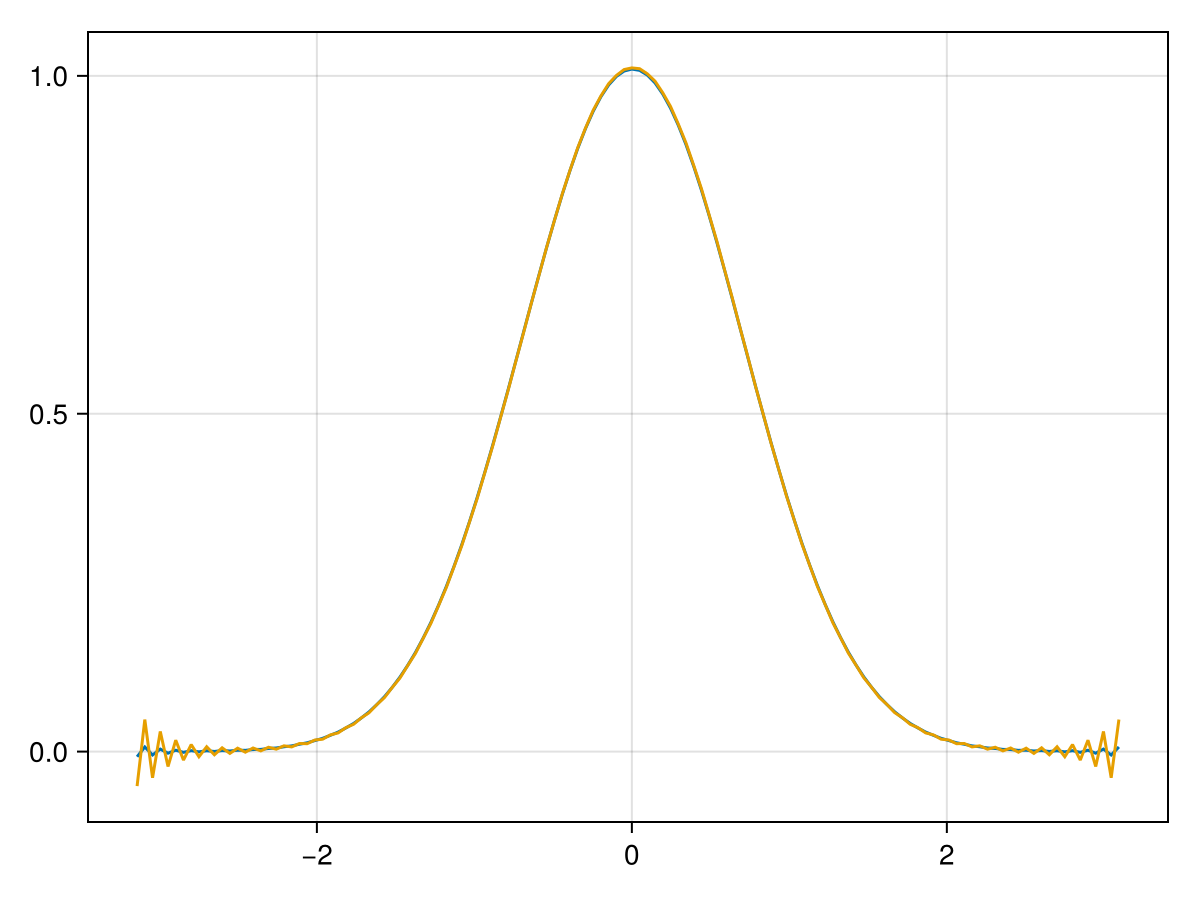

In [5]:
Πh1 = cumsum(Th1[end:-1:1])[end:-1:1]
println(sum(Th1))
fig = Figure()
ax = Axis(fig[1,1])
lines!(ax, grid.x, u1)
lines!(ax, grid.x, u2)

fig